## Import 

In [1]:
# Import certain functions that don't exist in early python
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Import certain scripts from the Graph Nets Library
from graph_nets import utils_tf
from graph_nets import utils_np
from graph_nets import modules

# Import tensorflow and sonnet
import tensorflow as tf
import sonnet as snt

#import basic libraries
import numpy as np
import matplotlib.pyplot as plt
import copy

try:
  import seaborn as sns
except ImportError:
  pass
else:
  sns.reset_orig()

# Set random seed
rng = np.random.default_rng()

## Helper Functions

In [2]:
## Functions for TF session

def make_output_graph(raw_input_graph, raw_output_graph):
    new_globals = raw_input_graph.globals
    timestep = tf.constant(0.04, dtype='float64')
    two = tf.constant(2.,   dtype='float64')
    old_pos = raw_input_graph.nodes[:, 0:3]
    old_vel = raw_input_graph.nodes[:, 3:6]
    old_accel = raw_input_graph.nodes[:, 6:9]
    old_lift = raw_input_graph.nodes[:, 9:12]
    new_accel = raw_output_graph.nodes[:, 0:3]
    accel = tf.math.divide(tf.math.add(old_accel, new_accel), two)  
    new_vel = tf.math.add(old_vel, tf.math.multiply(accel, timestep))
    vel = tf.math.divide(tf.math.add(old_vel, new_vel), two) 
    new_pos = tf.math.add(old_pos, tf.math.multiply(vel, timestep))
    new_lift = raw_output_graph.nodes[:, 3:6]
    new_nodes = tf.concat([new_pos, new_vel, new_accel, new_lift], axis=1)
    new_edges = raw_input_graph.edges
    output_graph = raw_output_graph.replace(globals=new_globals, nodes=new_nodes, edges=new_edges) 
    return output_graph



def make_raw_input_graph(input_graph, input_Vinf):
    Vinf_tf = tf.constant(input_Vinf, dtype='float64')
    new_globals = tf.concat([Vinf_tf[:, 0:1], input_graph.globals[:, 1:3]], axis=1)
    new_nodes = input_graph.nodes
    new_edges = input_graph.edges
    raw_input_graph = input_graph.replace(globals=new_globals, nodes=new_nodes, edges=new_edges) 
    return raw_input_graph



def loss_func(output_graphs, target_graphs):
    nodal_diff = tf.math.subtract(output_graphs.nodes[:, 6:12], target_graphs.nodes[:, 6:12])
    nodal_sqr_err = tf.math.square(nodal_diff)
    nodal_sum_sqr_err = tf.math.reduce_sum(nodal_sqr_err, axis=1)
    nodal_mean_sqr_err = tf.math.reduce_mean(nodal_sum_sqr_err)
    return nodal_mean_sqr_err



def rollout_model(model, initial_input_graph, input_Vinfs):
    # find out how many timesteps are needed,
    num_steps = np.shape(input_Vinfs)[1]
    # setup list of graphs at each timestep
    output_graph_list = [initial_input_graph]
    for step in range(1, num_steps):
        raw_input_graph = make_raw_input_graph(output_graph_list[step-1], input_Vinfs[:,step:step+1])
        raw_output_graph = model(raw_input_graph)
        raw_output_graph = raw_output_graph[-1]
        output_graph = make_output_graph(raw_input_graph, raw_output_graph)
        output_graph_list.append(output_graph)
    return output_graph_list

In [3]:
### Functions for post-proccesing

def lift_from_dynamic_sim(graph_dict_list):
    num_steps = len(graph_dict_list)
    lift = np.zeros((num_steps), dtype = 'float64')
    for step in range(num_steps):
        lift[step] = np.sum(graph_dict_list[step]["nodes"][:, 11])
    return lift



def deflection_from_dynamic_sim(graph_dict_list):
    timesteps = len(graph_dict_list)
    deflection = np.zeros((timesteps), dtype = 'float64')
    for i in range(timesteps):
        deflection[i] = graph_dict_list[i]["nodes"][-1,2]
    return deflection



def accel_from_dynamic_sim(graph_dict_list):
    timesteps = len(graph_dict_list)
    accel = np.zeros((timesteps), dtype = 'float64')
    for i in range(timesteps):
        accel[i] = graph_dict_list[i]["nodes"][-1,8]
    return accel

## Helper Classes

In [4]:
class Node:  
    
  def __init__(self, forces, pos, vel, accel):
    self.pos = np.array(pos,    dtype=np.float64)
    self.vel = np.array(vel,    dtype=np.float64)
    self.accel = np.array(accel,  dtype=np.float64)
    self.force = np.array(forces, dtype=np.float64)



class Sharpy_Sim:
    
  def __init__(self, sharpy_data, force_data, pos_data, vel_data, accel_data):
    # Load data using arrays retreived from a SHARPy simulation
    self.time = np.array(sharpy_data[:, 1], dtype=np.float64)
    self.Vinf = np.array(sharpy_data[:, 2], dtype=np.float64)
    self.density = sharpy_data[0, 3]
    self.set_angle = sharpy_data[0, 4] / np.pi * 180
    # Load data at each nodal point in the wing 
    self.nodes = []                                      # set blank list of nodes
    self.num_nodes = int((np.shape(force_data)[1]) / 3)  # find number of nodes from an input array size
    for i in range(self.num_nodes):
        self.nodes.append(Node(force_data[:, 3*i : 3*(i+1)],
                               pos_data  [:, 3*i : 3*(i+1)],
                               vel_data  [:, 3*i : 3*(i+1)],
                               accel_data[:, 3*i : 3*(i+1)]))
    # Determine useful info about any given simulation
    self.num_steps = len(self.time)
    
  def Get_Lift(self):
    lift = np.zeros((self.num_steps), dtype=np.float64)
    for step in range(self.num_steps):
        lift_temp = 0.
        for node in self.nodes:
            lift_temp += node.force[step, 2]
        lift[step] = lift_temp
    return lift

  def Get_Deflection(self):
    deflection = np.zeros((self.num_steps), dtype=np.float64)
    for step in range(self.num_steps):
        deflection_temp = self.nodes[-1].pos[step, 2]
    deflection[step] = deflection_temp
    return deflection

  def Mirror(self):
    # Method to flip the z axis in the sharpy simulation (same physics apply due to lack of gravity)
    self.set_angle *= -1
    for i in range(self.num_nodes):
        self.nodes[i].force[:,2] *= -1
        self.nodes[i].pos[:,2] *= -1
        self.nodes[i].vel[:,2] *= -1
        self.nodes[i].accel[:,2] *= -1
    
  def Steady_State(self):
    # Method to turn this SHARPy simulation into a steady state response by repeating first timestep (before gust)
    self.Vinf = np.ones(self.num_steps) * self.Vinf[0]
    for i in range(self.num_nodes):
        self.nodes[i].pos[:,:] = self.nodes[i].pos[0,:]
        self.nodes[i].vel[:,:] = np.zeros([self.num_steps, 3])
        self.nodes[i].accel[:,:] = np.zeros([self.num_steps, 3])
        self.nodes[i].force[:,:] = self.nodes[i].force[0,:]
    
  def Create_Graph_Dict(self, step):
    # Method to return a dictionary which describes a graph of this simulation at certain timestep
    global_attributes = np.array([self.Vinf[step], self.density, self.set_angle], dtype=np.float64)
    node_attributes = np.zeros([self.num_nodes, 12], dtype=np.float64)
    for i in range(self.num_nodes):
        node_attributes[i, 0:3] = self.nodes[i].pos[step, :]
        node_attributes[i, 3:6] = self.nodes[i].vel[step, :]
        node_attributes[i, 6:9] = self.nodes[i].accel[step, :]
        node_attributes[i, 9:12] = self.nodes[i].force[step, :]
    edge_attributes = np.zeros([self.num_nodes*2 - 3, 0], dtype=np.float64)
    sender_nodes, receiver_nodes = [], []
    edge_index = 0
    for i in range(self.num_nodes - 1):
        left_node = i
        right_node = i + 1
        #always an outgoing edge
        edge_attributes[edge_index, :] = []
        edge_index += 1
        sender_nodes.append(left_node)
        receiver_nodes.append(right_node)
        #for all but first node there is always an incoming edge
        if left_node > 0 :
            # Right incoming edge.
            edge_attributes[edge_index ,:] = []
            edge_index += 1
            sender_nodes.append(right_node)
            receiver_nodes.append(left_node)
    return { "globals"  : global_attributes,
             "nodes"    : node_attributes,
             "edges"    : edge_attributes,
             "receivers": receiver_nodes,
             "senders"  : sender_nodes}



def make_mlp_model(NUM_LAYERS = 2, LATENT_SIZE = 16):
    return snt.Sequential([snt.nets.MLP([LATENT_SIZE] * NUM_LAYERS, activate_final=True), snt.LayerNorm()])

def make_graph_tuple_runnable(*args):
    return [utils_tf.make_runnable_in_session(a) for a in args]

def make_graph_tuple_list_runnable(graph_list):
    return [make_graph_tuple_runnable(graph_tuple) for graph_tuple in graph_list]



class MLPGraphIndependent(snt.AbstractModule):
  def __init__(self, name="MLPGraphIndependent"):
    super(MLPGraphIndependent, self).__init__(name=name)
    with self._enter_variable_scope():
      self._network = modules.GraphIndependent(edge_model_fn   = make_mlp_model,
                                               node_model_fn   = make_mlp_model,
                                               global_model_fn = make_mlp_model)
  def _build(self, inputs):
    return self._network(inputs)



class MLPGraphNetwork(snt.AbstractModule):
  def __init__(self, name="MLPGraphNetwork"):
    super(MLPGraphNetwork, self).__init__(name=name)
    with self._enter_variable_scope():
      self._network = modules.GraphNetwork(make_mlp_model, 
                                           make_mlp_model,
                                           make_mlp_model)
  def _build(self, inputs):
    return self._network(inputs)



class EncodeProcessDecode(snt.AbstractModule):
  def __init__(self,
               edge_output_size   = None,
               node_output_size   = None,
               global_output_size = None,
               name = "EncodeProcessDecode"):
    super(EncodeProcessDecode, self).__init__(name=name)
    self._encoder = MLPGraphIndependent()
    self._core = MLPGraphNetwork()
    self._decoder = MLPGraphIndependent()
    # Transforms the outputs into the appropriate shapes.
    if edge_output_size is None:
      edge_fn = None
    else:
      edge_fn = lambda: snt.Linear(edge_output_size, name="edge_output")
    if node_output_size is None:
      node_fn = None
    else:
      node_fn = lambda: snt.Linear(node_output_size, name="node_output")
    if global_output_size is None:
      global_fn = None
    else:
      global_fn = lambda: snt.Linear(global_output_size, name="global_output")
    with self._enter_variable_scope():
      self._output_transform = modules.GraphIndependent(edge_fn, node_fn,
                                                        global_fn)
  def _build(self, input_op, num_processing_steps):
    latent = input_op
    latent0 = latent
    output_ops = []
    for _ in range(num_processing_steps):
      core_input = utils_tf.concat([latent0, latent], axis=1)
      latent = self._core(core_input)
      decoded_op = latent
      output_ops.append(self._output_transform(decoded_op))
    return output_ops

## OPTIONS

In [5]:
# Amount of data
num_sims_tr = int(195)   # number of sims for training data
num_sims_ge = int(5)     # number of sims for test data

# Data Augmentation
augment_data_mirror = False
augment_data_steady = False

# Data Preperation
num_rollout_steps = 100

# Model Parameters
num_process_steps = 1
learning_rate = 1e-3

# Training
num_training_iterations = 10 * 1000

## Load SHARPy Training Data

In [6]:
# Load all training data
sharpy_sims = []
for i in range(num_sims_tr):
    # Load csv files into numpy arrays
    file_path = "Data/output_" + str(i) + "/" 
    sharpy_data = np.loadtxt(file_path + "Main_SHARPy_Data.csv", skiprows=1, delimiter=',')
    aero_forces = np.loadtxt(file_path + "Aero_Forces.csv", skiprows=1, delimiter=',') 
    positions = np.loadtxt(file_path + "Positions.csv", skiprows=1, delimiter=',')
    velocities = np.loadtxt(file_path + "Velocities.csv", skiprows=1, delimiter=',')
    accelerations = np.loadtxt(file_path + "Accelerations.csv", skiprows=1, delimiter=',')
    # Build a SHARPy object for each simulation
    sharpy_run = Sharpy_Sim(sharpy_data, aero_forces, positions, velocities, accelerations)
    # Add each SHARPy object to the list of simulations
    sharpy_sims.append(sharpy_run)
    ## Add Corresponding augmentated cases
    if augment_data_mirror:
        sharpy_mirror_copy = copy.deepcopy(sharpy_run)
        sharpy_mirror_copy.Mirror()
        sharpy_sims.append(sharpy_mirror_copy)
    if augment_data_steady:
        sharpy_steady_copy = copy.deepcopy(sharpy_run)
        sharpy_steady_copy.Steady_State()
        sharpy_sims.append(sharpy_steady_copy)
    

## Load SHARPy Test Data

In [7]:
# Load all testing data
for i in range(num_sims_tr, num_sims_tr+num_sims_ge):
    # Load csv files into numpy arrays
    file_path = "Data/output_" + str(i) + "/" 
    sharpy_data = np.loadtxt(file_path + "Main_SHARPy_Data.csv", skiprows=1, delimiter=',')
    aero_forces   = np.loadtxt(file_path + "Aero_Forces.csv", skiprows=1, delimiter=',')
    positions     = np.loadtxt(file_path + "Positions.csv", skiprows=1, delimiter=',')
    velocities    = np.loadtxt(file_path + "Velocities.csv", skiprows=1, delimiter=',')
    accelerations = np.loadtxt(file_path + "Accelerations.csv", skiprows=1, delimiter=',')
    # Build a SHARPy object for each simulation
    sharpy_run = Sharpy_Sim(sharpy_data, aero_forces, positions, velocities, accelerations)
    # Add each SHARPy object to the list of simulations
    sharpy_sims.append(sharpy_run)
    
    # Find number new number of sharpy training sims with augmentation
    num_sims = len(sharpy_sims)
    num_sims_tr = num_sims - num_sims_ge

## Create Graphs for Training

In [8]:
# Initialise lists
input_graphs_tr = []
input_Vinfs_array_tr = np.zeros((num_sims_tr, num_rollout_steps), dtype=np.float64)
target_graphs_list_tr = [[] for rollout_step in range(num_rollout_steps)]

# Loop through each training case
for sim_no in range(num_sims_tr):
    
    # Select a Random start point and add to training data
    num_steps = sharpy_sims[sim_no].num_steps
    start_step = rng.integers(low=0, high=(num_steps - num_rollout_steps), dtype=np.int32, endpoint=False)
    stop_step = start_step + num_rollout_steps

    # Turn First Graph into an initial base graph
    input_graph = sharpy_sims[sim_no].Create_Graph_Dict(start_step)
    input_graphs_tr.append(input_graph)

    # Collect Vinf inputs require for future inputs
    input_Vinfs_array_tr[sim_no, :] = sharpy_sims[sim_no].Vinf[start_step:stop_step]

    # Collect Target Graphs for future points in the timeseries
    for rollout_step in range(num_rollout_steps):
        target_graphs_list_tr[rollout_step].append(sharpy_sims[sim_no].Create_Graph_Dict(start_step+rollout_step))

In [9]:
# Convert graph dictionary lists into GraphTuples
input_graphs_tr = utils_tf.data_dicts_to_graphs_tuple(input_graphs_tr)

for rollout_step in range(num_rollout_steps):
    target_graphs_list_tr[rollout_step] = utils_tf.data_dicts_to_graphs_tuple(target_graphs_list_tr[rollout_step])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Create Graphs for Testing

In [10]:
# Initialise lists
input_graph_list_ge = []
input_Vinfs_list_ge = []
target_graphs_list_ge = []

# Loop through each test case
for sim_no in range(num_sims_tr, num_sims):

    # Set start and stop steps
    num_steps = sharpy_sims[sim_no].num_steps
    start_step = 0
    stop_step = start_step + num_rollout_steps
    stop_step = num_steps
    
    # Turn First Graph into an initial base graph
    initial_base_graph = sharpy_sims[sim_no].Create_Graph_Dict(start_step)

    # Collect Vinf inputs require for future inputs
    input_Vinfs = sharpy_sims[sim_no].Vinf[start_step:stop_step]
    input_Vinfs = np.array([input_Vinfs])

    # Collect Target Graphs for future points in the timeseries
    target_graphs = []
    for step in range(start_step, stop_step):
        target_graphs.append(sharpy_sims[sim_no].Create_Graph_Dict(step))

    # Append graph and vinf input, and the target graphs to a list of training points
    input_graph_list_ge.append([initial_base_graph])
    input_Vinfs_list_ge.append(input_Vinfs)
    target_graphs_list_ge.append(target_graphs)

In [11]:
for case_ge in range(num_sims_ge):
    input_graph_list_ge[case_ge] = utils_tf.data_dicts_to_graphs_tuple(input_graph_list_ge[case_ge])  
    target_graphs_list_ge[case_ge] = utils_tf.data_dicts_to_graphs_tuple(target_graphs_list_ge[case_ge])

## Create  Model & Setup Training

In [12]:
# Initialise model
model = EncodeProcessDecode(global_output_size = None,
                            node_output_size = 6,
                            edge_output_size = None)

In [13]:
output_graphs_list_tr = rollout_model(lambda x: model(x, num_process_steps),
                                      input_graphs_tr,
                                      input_Vinfs_array_tr)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [14]:
# For each rollout step find the loss
loss_tr = tf.constant(0, dtype=np.float64)
for rollout_step in range(1, num_rollout_steps):  # Miss out input graph as error is always zero
    loss = loss_func(output_graphs_list_tr[rollout_step], target_graphs_list_tr[rollout_step])
    loss_tr = tf.add(loss_tr, loss)

num_rollout_steps_tf = tf.constant(num_rollout_steps, dtype=np.float64)
loss_tr = tf.math.divide(loss_tr, num_rollout_steps_tf)

In [15]:
# Optimizer.
optimizer = tf.train.AdamOptimizer(learning_rate)
step_op = optimizer.minimize(loss_tr)

In [16]:
# Make Graph runnable in tensorflow session
input_graphs_tr = make_graph_tuple_runnable(input_graphs_tr)

## Setup Testing

In [17]:
# get the actual model outputs from the setup test inputs
output_graphs_list_ge = []

# Implement Rollout
for case_ge in range(num_sims_ge):
    input_graph = input_graph_list_ge[case_ge]
    input_Vinfs = input_Vinfs_list_ge[case_ge]
    output_graphs = rollout_model(lambda x: model(x, num_process_steps),
                                  input_graph,
                                  input_Vinfs)
    output_graphs = utils_tf.concat(output_graphs, axis=0)
    output_graphs_list_ge.append(output_graphs)

In [18]:
# For each output per processing step find the loss function
loss_ge = tf.constant(0, dtype=np.float64)
for case_ge in range(num_sims_ge):
    loss = loss_func(output_graphs_list_ge[case_ge], target_graphs_list_ge[case_ge])
    loss_ge = tf.add(loss_ge, loss)

num_sims_tf = tf.constant(num_sims_ge, dtype=np.float64)
loss_ge = tf.math.divide(loss_ge, num_sims_tf)

In [19]:
# Make Graph runnable in tensorflow session
for case_ge in range(num_sims_ge):
    input_graph_list_ge[case_ge] = make_graph_tuple_runnable(input_graph_list_ge[case_ge])

## Reset Session

In [20]:
# This cell resets the Tensorflow session, but keeps the same computational
# graph.

try:
  sess.close()
except NameError:
  pass
sess = tf.Session()
sess.run(tf.global_variables_initializer())

last_iteration = 0
logged_iterations = []
losses_tr = []
losses_ge = []

2023-09-23 18:18:45.083891: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-23 18:18:45.087680: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3792000000 Hz
2023-09-23 18:18:45.087961: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5085560 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-09-23 18:18:45.087987: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
OMP: Info #155: KMP_AFFINITY: Initial OS proc set respected: 0-3
OMP: Info #216: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #157: KMP_AFFINITY: 4 available OS procs
OMP: Info #158: KMP_AFFINITY: Uniform topology
OMP: Info #287:

## Training

In [21]:
# set number of iterations and time between logs
log_every_iteration = 200
last_log_iteration = 0

In [22]:
# output header
print("# (iteration number), "
      "Loss (training 1-step loss), "
      "Loss (test - full rollout)")

# train for a certain amount of iterations
for iteration in range(last_iteration, num_training_iterations+1):
    
    # log number of completed iterations
    last_iteration = iteration
    
    # if it has been long enough, log data
    if (iteration-last_log_iteration) >= log_every_iteration:
        
        last_log_iteration = iteration
        
        # run test TensorFlow session
        test_values = sess.run( { "loss"   : loss_ge,
                                  "output" : output_graphs_list_ge,
                                  "target" : target_graphs_list_ge
                                  } )
        
        # log values
        losses_tr.append(train_values["loss"])
        losses_ge.append(test_values["loss"])
        logged_iterations.append(iteration)
    
        print("# {:05d}, Ltrain {:.4f}, Ltest (test) {:.4f}".format(iteration,  
                                                                    train_values["loss"], 
                                                                    test_values["loss"]))
    
    # Run Tensorflow session of training graphs set
    train_values = sess.run( { "step"   : step_op,
                               "loss"   : loss_tr,
                               "output" : output_graphs_list_tr,
                               "target" : target_graphs_list_tr
                                } )

# (iteration number), Loss (training 1-step loss), Loss (test - full rollout)


OMP: Info #254: KMP_AFFINITY: pid 665 tid 694 thread 1 bound to OS proc set 1
OMP: Info #254: KMP_AFFINITY: pid 665 tid 696 thread 2 bound to OS proc set 2
OMP: Info #254: KMP_AFFINITY: pid 665 tid 697 thread 3 bound to OS proc set 3
OMP: Info #254: KMP_AFFINITY: pid 665 tid 698 thread 4 bound to OS proc set 0
OMP: Info #254: KMP_AFFINITY: pid 665 tid 693 thread 5 bound to OS proc set 1
OMP: Info #254: KMP_AFFINITY: pid 665 tid 699 thread 6 bound to OS proc set 2
OMP: Info #254: KMP_AFFINITY: pid 665 tid 700 thread 7 bound to OS proc set 3
OMP: Info #254: KMP_AFFINITY: pid 665 tid 701 thread 8 bound to OS proc set 0


# 00200, Ltrain 0.8225, Ltest (test) 0.6758
# 00400, Ltrain 0.4663, Ltest (test) 0.4730
# 00600, Ltrain 0.3977, Ltest (test) 0.4578
# 00800, Ltrain 0.3566, Ltest (test) 0.4317
# 01000, Ltrain 0.5771, Ltest (test) 0.5224
# 01200, Ltrain 0.3893, Ltest (test) 0.4201
# 01400, Ltrain 0.3472, Ltest (test) 0.4131
# 01600, Ltrain 0.4012, Ltest (test) 0.4107
# 01800, Ltrain 0.3302, Ltest (test) 0.3961
# 02000, Ltrain 0.3187, Ltest (test) 0.3808
# 02200, Ltrain 0.3365, Ltest (test) 0.3765
# 02400, Ltrain 0.2935, Ltest (test) 0.3743
# 02600, Ltrain 0.2746, Ltest (test) 0.3376
# 02800, Ltrain 0.2621, Ltest (test) 0.3310
# 03000, Ltrain 0.2458, Ltest (test) 0.3188
# 03200, Ltrain 0.2208, Ltest (test) 0.2941
# 03400, Ltrain 0.2074, Ltest (test) 0.2840
# 03600, Ltrain 0.2054, Ltest (test) 0.2635
# 03800, Ltrain 0.1880, Ltest (test) 0.2701
# 04000, Ltrain 0.1639, Ltest (test) 0.2597
# 04200, Ltrain 0.1508, Ltest (test) 0.2452
# 04400, Ltrain 0.1446, Ltest (test) 0.2255
# 04600, Ltrain 0.1335, Ltest (t

## Process Data

In [23]:
# Iteration number for logged losses
iterations = np.array(logged_iterations)
 
# Gather test output
model_outputs = test_values["output"]
model_targets = test_values["target"]

In [24]:
# Turn numpy graph tuples into graph dictionaries
for i in range(num_sims_ge):
    model_outputs[i] = utils_np.graphs_tuple_to_data_dicts(model_outputs[i])
    model_targets[i] = utils_np.graphs_tuple_to_data_dicts(model_targets[i])

## Plot Loss Curves

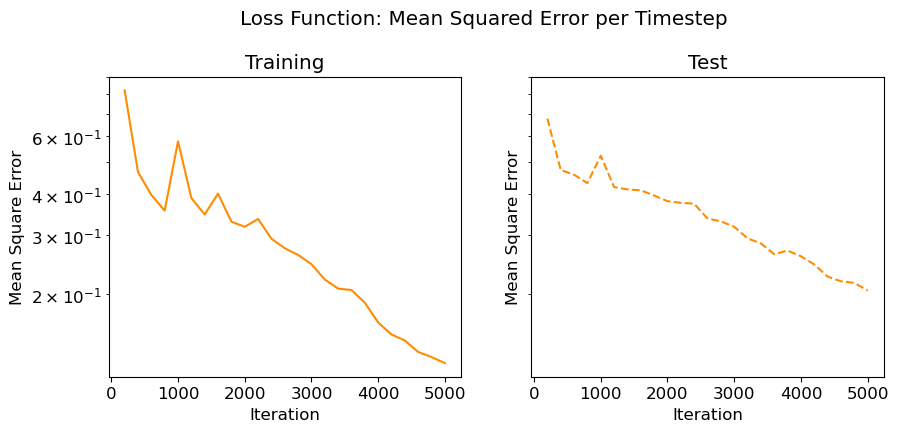

In [25]:
# Define plot parameters
plt.rcParams.update({'font.size': 12,
                     "text.usetex": False}) 

# Clear exisiting figure and create new one
fig, (ax_left, ax_right) =  plt.subplots(1,2, sharey=True, figsize=(10,3.75))


# Format figure
fig.suptitle('Loss Function: Mean Squared Error per Timestep')
fig.subplots_adjust(left=None, right=None, bottom=0, top=3/3.75, wspace=None, hspace=None)

# Plot training loss
x = iterations
y = losses_tr
ax_left.plot(x, y, color='darkorange', marker='', linestyle='-')
# Format
ax_left.set_title("Training")
ax_left.set_xlabel("Iteration")
ax_left.set_ylabel("Mean Square Error")
ax_left.set_yscale("log")

# Plot test loss
x = iterations
y = losses_ge
ax_right.plot(x, y, color='darkorange', marker='', linestyle='--')
# Format
ax_right.set_title("Test")
ax_right.set_xlabel("Iteration")
ax_right.set_ylabel("Mean Square Error")
ax_right.set_yscale("log")

# Show
plt.show()

## Test Cases

/home/brutledge/anaconda3/envs/GraphNetOld/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


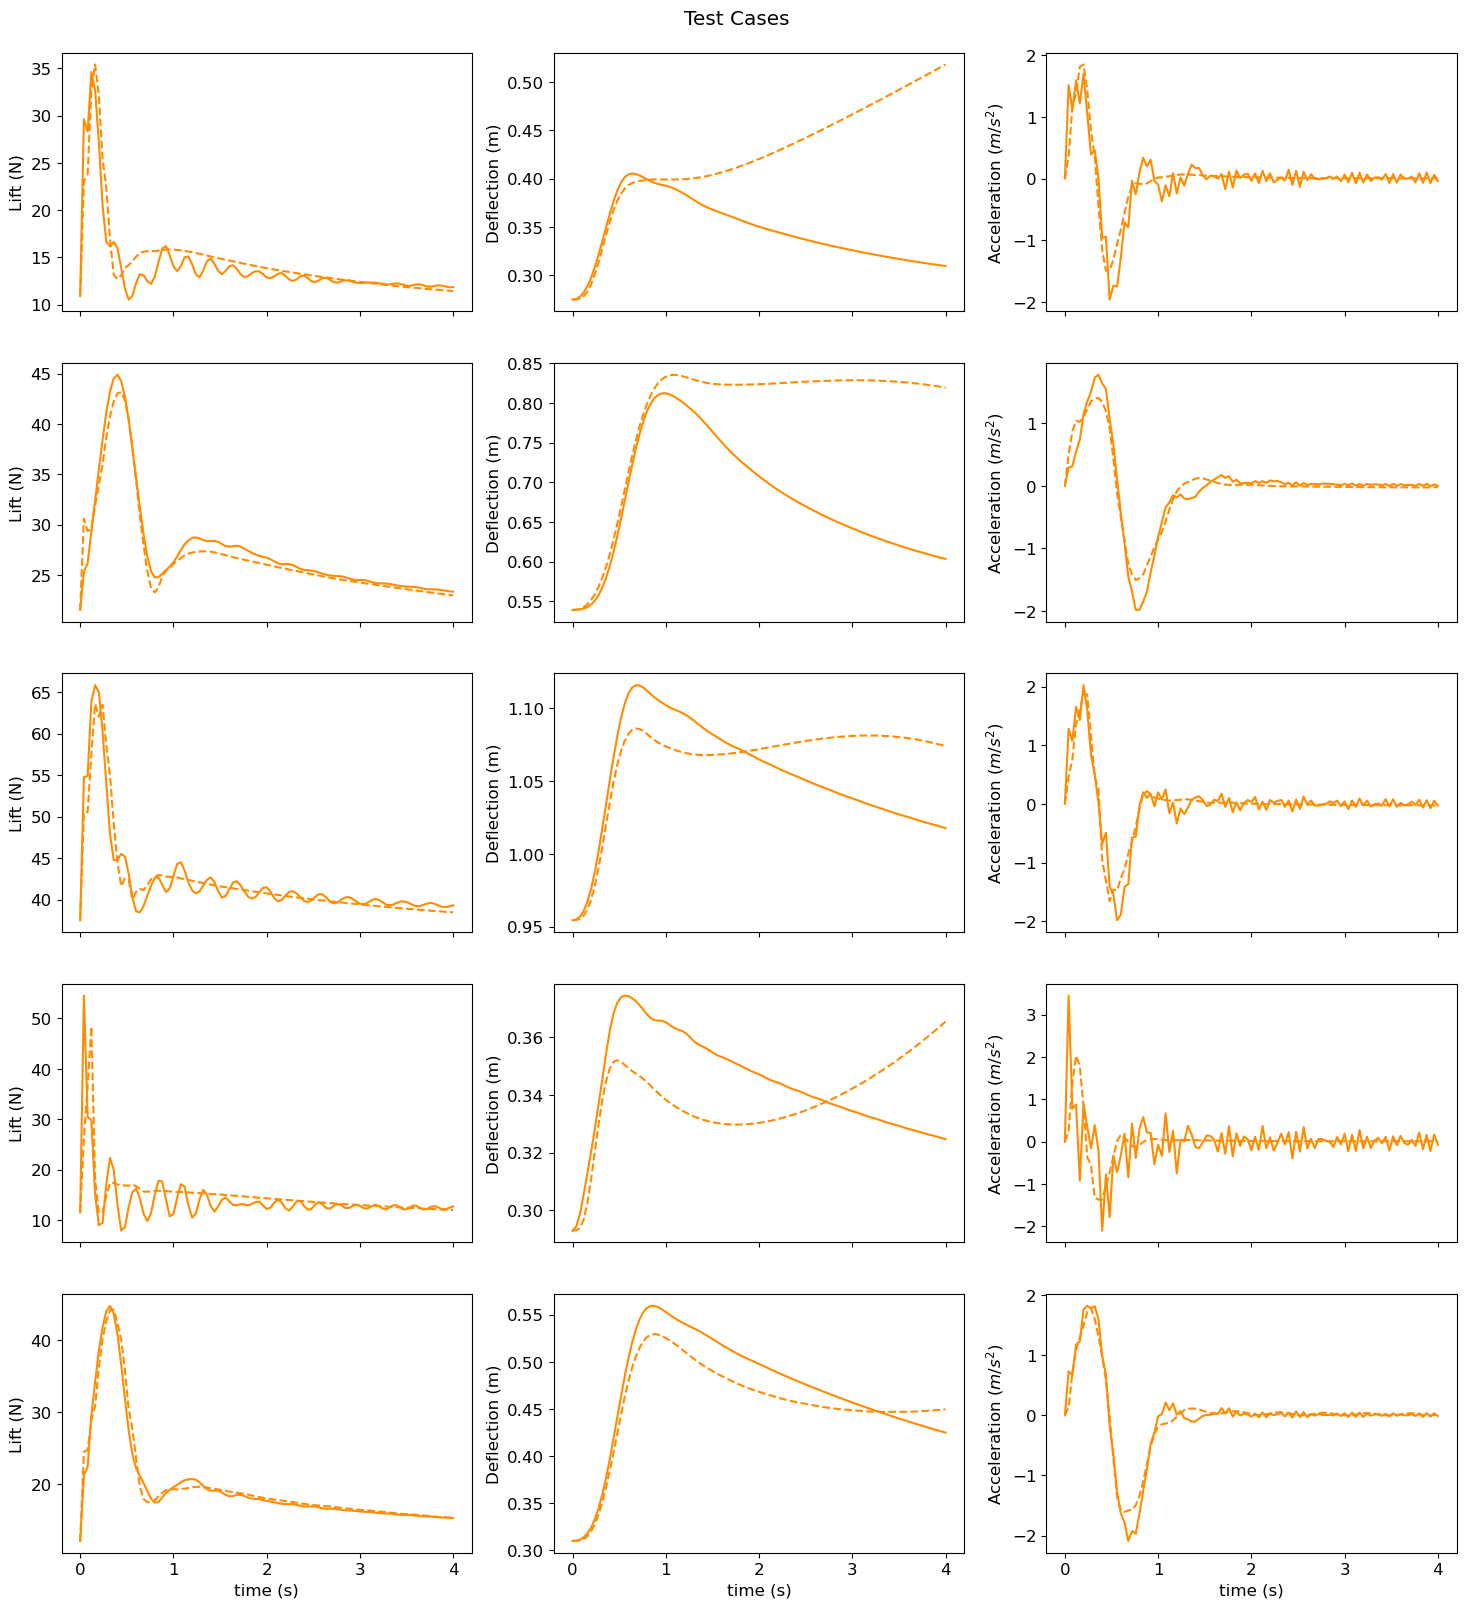

In [26]:
# Clear exisiting figure and create new one
fig.clf()
fig, axs = plt.subplots(num_sims_ge, 3, sharex=True, figsize=(18, 3*num_sims_ge+0.75))

# Format figure
fig.suptitle('Test Cases')
fig.subplots_adjust(left=None, right=None, bottom=0, top=(3*num_sims_ge)/(3*num_sims_ge+0.75), wspace=None, hspace=None)

# Find time for test runs
time = np.linspace(0, 4, 101)

# Iterate through each test case
for test_case in range(num_sims_ge):
    
    # Get the relevant graph dicts
    test_output = model_outputs[test_case]
    test_target = model_targets[test_case]
    # Get lift
    lift_ge = lift_from_dynamic_sim(test_output)
    lift    = lift_from_dynamic_sim(test_target)
    # Get tip deflection
    defl_ge = deflection_from_dynamic_sim(test_output)
    defl    = deflection_from_dynamic_sim(test_target)
    # Get tip acceleration
    accel_ge = accel_from_dynamic_sim(test_output)
    accel    = accel_from_dynamic_sim(test_target)
    
    # Plot lift
    x = time
    y = lift
    axs[test_case, 0].plot(x, y, color='darkorange', marker='', linestyle='-')
    # Plot true lift
    x = time
    y = lift_ge
    axs[test_case, 0].plot(x, y, color='darkorange', marker='', linestyle='--')
    # Format
    axs[test_case, 0].set_ylabel("Lift (N)")
    
    # Plot true deflection
    x = time
    y = defl
    axs[test_case, 1].plot(x, y, color='darkorange', marker='', linestyle='-')
    # Plot deflection
    x = time
    y = defl_ge
    axs[test_case, 1].plot(x, y, color='darkorange', marker='', linestyle='--')
    # Format
    axs[test_case, 1].set_ylabel("Deflection (m)")
    
    # Plot true acceleraton
    x = time
    y = accel
    axs[test_case, 2].plot(x, y, color='darkorange', marker='', linestyle='-')
    # Plot acceleration
    x = time
    y = accel_ge
    axs[test_case, 2].plot(x, y, color='darkorange', marker='', linestyle='--')
    # Format
    axs[test_case, 2].set_ylabel("Acceleration ($m/s^2$)")
    
    
    
# Add xlabel to bottom
axs[-1,0].set_xlabel("time (s)")
axs[-1,1].set_xlabel("time (s)")
axs[-1,2].set_xlabel("time (s)")

# Show plot
plt.show()    